# Boston Housing Prices

In [6]:
#import required libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

from sklearn.decomposition import PCA
import xgboost as xg

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from mlxtend.regressor import StackingRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn import  metrics
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from mlxtend.regressor import StackingCVRegressor

In [7]:
#load the dataset
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [8]:
df_train.shape

(1460, 81)

In [9]:
df_test.shape

(1459, 80)

## Data cleaning and Feature Engineering

In [10]:
#explore the dataset for missing values, data types, etc. 
missing_index = df_train.columns[df_train.isnull().any()]
missing_index_test = df_test.columns[df_test.isnull().any()]

In [11]:
#percent of missing values
(df_train.loc[:,missing_index].isna().sum()/1460).round(2)

LotFrontage     0.18
Alley           0.94
MasVnrType      0.01
MasVnrArea      0.01
BsmtQual        0.03
BsmtCond        0.03
BsmtExposure    0.03
BsmtFinType1    0.03
BsmtFinType2    0.03
Electrical      0.00
FireplaceQu     0.47
GarageType      0.06
GarageYrBlt     0.06
GarageFinish    0.06
GarageQual      0.06
GarageCond      0.06
PoolQC          1.00
Fence           0.81
MiscFeature     0.96
dtype: float64

In [12]:
(df_test.loc[:,missing_index_test].isna().sum()/1460).round(2)

MSZoning        0.00
LotFrontage     0.16
Alley           0.93
Utilities       0.00
Exterior1st     0.00
Exterior2nd     0.00
MasVnrType      0.01
MasVnrArea      0.01
BsmtQual        0.03
BsmtCond        0.03
BsmtExposure    0.03
BsmtFinType1    0.03
BsmtFinSF1      0.00
BsmtFinType2    0.03
BsmtFinSF2      0.00
BsmtUnfSF       0.00
TotalBsmtSF     0.00
BsmtFullBath    0.00
BsmtHalfBath    0.00
KitchenQual     0.00
Functional      0.00
FireplaceQu     0.50
GarageType      0.05
GarageYrBlt     0.05
GarageFinish    0.05
GarageCars      0.00
GarageArea      0.00
GarageQual      0.05
GarageCond      0.05
PoolQC          1.00
Fence           0.80
MiscFeature     0.96
SaleType        0.00
dtype: float64

In [13]:
#Therefore for Alley, PoolQC, Fence and MiscFeature majority of the values are missing. Therefore these columns are removed from the test and train datasets
drop_columns = ['Alley','PoolQC','Fence','MiscFeature']
df_train.drop(drop_columns,axis = 1,inplace=True)
df_test.drop(drop_columns,axis=1,inplace=True)

In [14]:
#Concatenate the two datasets together for cleaning and feature engineering
df = pd.concat([df_train,df_test],axis=0,sort=False)
df.reset_index(inplace=True,drop=True)

In [15]:
df.shape

(2919, 77)

In [16]:
df.loc[:,df.columns[df.isnull().any()]].isna().sum()

MSZoning           4
LotFrontage      486
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
MasVnrArea        23
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinSF1         1
BsmtFinType2      80
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageYrBlt      159
GarageFinish     159
GarageCars         1
GarageArea         1
GarageQual       159
GarageCond       159
SaleType           1
SalePrice       1459
dtype: int64

In [17]:
#A lot of the columns have missing values because the input was NA which means that the feature was not avaialble. Therefore, these values can be filled with a string "None" as "no" is already used as a response

fill_columns = ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','GarageType','GarageFinish','GarageQual','GarageCond','FireplaceQu']
df[fill_columns] = df[fill_columns].fillna("None")

In [18]:
df.loc[:,df.columns[df.isnull().any()]].isna().sum()

MSZoning           4
LotFrontage      486
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
MasVnrArea        23
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
GarageYrBlt      159
GarageCars         1
GarageArea         1
SaleType           1
SalePrice       1459
dtype: int64

In [19]:
#It will be easier to conduct futher cleaning by splitting the data in numberical and categorial data
object_df = df.select_dtypes(include=['object'])
numerical_df =df.select_dtypes(exclude=['object'])

In [20]:
#Lets look at the numerical missing values first
numerical_df.loc[:,numerical_df.columns[numerical_df.isnull().any()]].isna().sum()

LotFrontage      486
MasVnrArea        23
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
BsmtFullBath       2
BsmtHalfBath       2
GarageYrBlt      159
GarageCars         1
GarageArea         1
SalePrice       1459
dtype: int64

Text(0.5, 1.0, 'Sale price vs lot frontage')

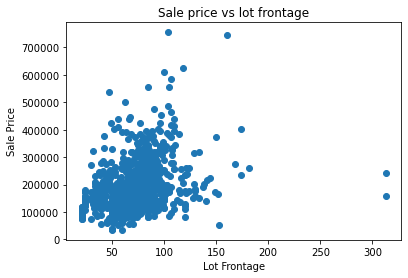

In [21]:
#Lot frontage might affect pricing, lets visualize the change of price with respect to frontage area to decide if these values should be imputed or dropped
plt.scatter(numerical_df['LotFrontage'],numerical_df['SalePrice'])
plt.xlabel("Lot Frontage")
plt.ylabel("Sale Price")
plt.title("Sale price vs lot frontage")

In [22]:
#From the above we can see that there seems to be a positive correlation between price and lot frontage. To verify this the correaletion matrix can be plotted
corr = numerical_df.loc[:,['LotFrontage','SalePrice']].corr()

Text(0.5, 1.0, 'Correleation between lot frontage and price')

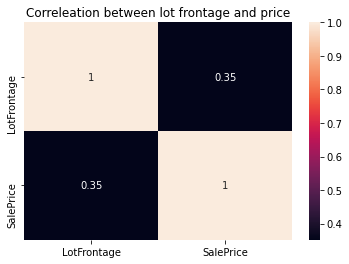

In [23]:
sns.heatmap(corr,annot=True)
plt.title("Correleation between lot frontage and price")

Text(0.5, 1.0, 'Lot Area vs lot frontage')

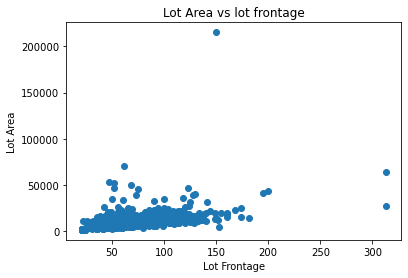

In [24]:
#It might be beneficial to impute the values of lotfrontage based on another variable as opposed to using mean or median
#In my opinion, lot frontage and area might be correleted
plt.scatter(numerical_df['LotFrontage'],numerical_df['LotArea'])
plt.xlabel("Lot Frontage")
plt.ylabel("Lot Area")
plt.title("Lot Area vs lot frontage")

Text(0.5, 1.0, 'Correleation between lot frontage and area')

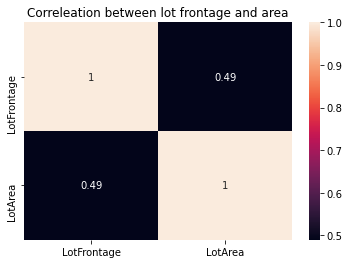

In [25]:
corr = numerical_df.loc[:,['LotFrontage','LotArea']].corr()
sns.heatmap(corr,annot=True)
plt.title("Correleation between lot frontage and area")

In [26]:
#Since the lot area and frontage area seem to have decent cooreletion, the values of frontage can be calulcated by linear regression
df_area = numerical_df.dropna(axis=0,subset=['LotArea','LotFrontage']).loc[:,['LotArea','LotFrontage']]

In [27]:
# We need to extract our missing values and corresponding lot area values
missing_frontage = numerical_df['LotFrontage'].isnull()
area_frontage = pd.DataFrame(numerical_df['LotArea'][missing_frontage])

In [28]:
missing_index = list(area_frontage.index)

In [29]:
X = df_area[['LotArea']]
y = df_area['LotFrontage']

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42,test_size=0.2)

lm = LinearRegression().fit(X_train,y_train)

In [30]:
y_pred = lm.predict(X_test)
mean_squared_error(y_test,y_pred,squared=False)

19.434471293410873

In [31]:
#These values still have some error but are more accurate than imputing with mean or median
frontage_values = pd.DataFrame(lm.predict(area_frontage))
frontage_values.index = missing_index

In [32]:
numerical_df.loc[:,'LotFrontage'] = numerical_df['LotFrontage'].fillna(frontage_values[0])

In [33]:
numerical_df.loc[:,numerical_df.columns[numerical_df.isnull().any()]].isna().sum()

MasVnrArea        23
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
BsmtFullBath       2
BsmtHalfBath       2
GarageYrBlt      159
GarageCars         1
GarageArea         1
SalePrice       1459
dtype: int64

In [34]:
#Garage year built is likely to be close to when the house was built, all other columns are filled with their mean values
missing_garage_year = numerical_df['GarageYrBlt'].isnull()
year_house_built = pd.DataFrame(numerical_df['YearBuilt'][missing_garage_year])
numerical_df.loc[:,'GarageYrBlt'] = numerical_df['GarageYrBlt'].fillna(year_house_built['YearBuilt'])

In [35]:
remaining_missing = list(numerical_df.columns[numerical_df.isnull().any()])[:-1]

In [36]:
numerical_df.loc[:,remaining_missing] = numerical_df.loc[:,remaining_missing].apply(lambda x: x.fillna(x.mean()),axis=0)

In [37]:
#Only missing values remaining are now from the test dataset
numerical_df.loc[:,numerical_df.columns[numerical_df.isnull().any()]].isna().sum()

SalePrice    1459
dtype: int64

In [38]:
#Categorial values
object_df.loc[:,object_df.columns[object_df.isnull().any()]].isna().sum()

MSZoning        4
Utilities       2
Exterior1st     1
Exterior2nd     1
MasVnrType     24
Electrical      1
KitchenQual     1
Functional      2
SaleType        1
dtype: int64

TA    1492
Gd    1151
Ex     205
Fa      70
Name: KitchenQual, dtype: int64

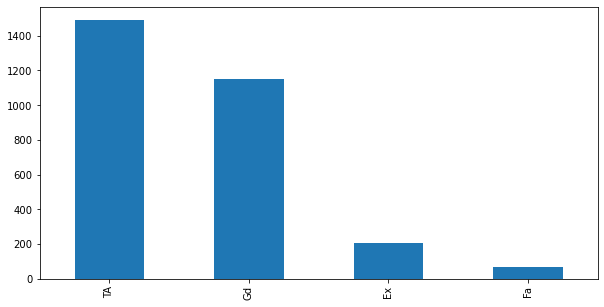

In [39]:
object_df['KitchenQual'].value_counts().plot(kind='bar',figsize=(10,5))
object_df['KitchenQual'].value_counts() 

WD       2525
New       239
COD        87
ConLD      26
CWD        12
ConLI       9
ConLw       8
Oth         7
Con         5
Name: SaleType, dtype: int64

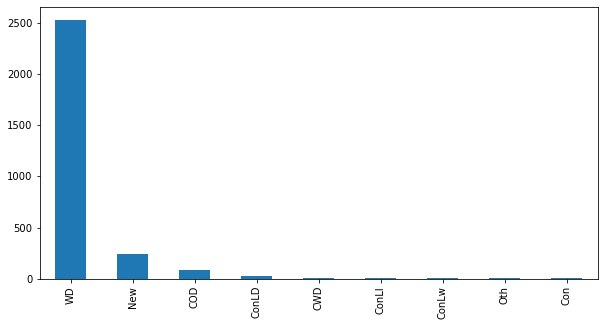

In [40]:
object_df['SaleType'].value_counts().plot(kind='bar',figsize=(10,5))
object_df['SaleType'].value_counts() 

None       1742
BrkFace     879
Stone       249
BrkCmn       25
Name: MasVnrType, dtype: int64

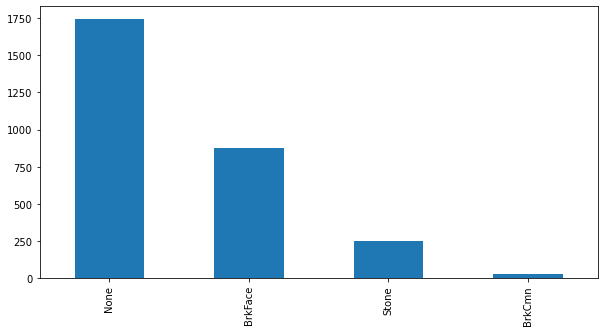

In [41]:
object_df['MasVnrType'].value_counts().plot(kind='bar',figsize=(10,5))
object_df['MasVnrType'].value_counts() 

RL         2265
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64

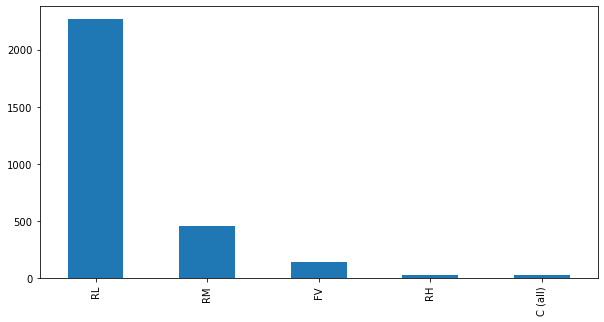

In [42]:
object_df['MSZoning'].value_counts().plot(kind='bar',figsize=(10,5))
object_df['MSZoning'].value_counts() 

AllPub    2916
NoSeWa       1
Name: Utilities, dtype: int64

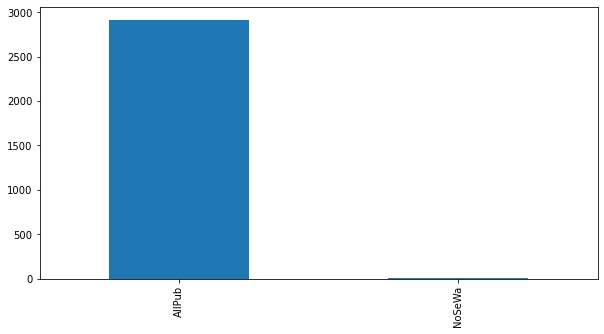

In [43]:
object_df['Utilities'].value_counts().plot(kind='bar',figsize=(10,5))
object_df['Utilities'].value_counts() 

In [44]:
object_df = object_df.drop(['Utilities'],axis=1)

In [45]:
object_df = object_df.apply(lambda x: x.fillna(x.mode()[0]),axis=0)

### Feature Engineering

In [46]:
#Age of house can be computed by subtracting the year sold and year built
numerical_df['House_age']= numerical_df['YrSold']-numerical_df['YearBuilt']
numerical_df['House_age'].describe()

count    2919.000000
mean       36.479959
std        30.336182
min        -1.000000
25%         7.000000
50%        35.000000
75%        54.500000
max       136.000000
Name: House_age, dtype: float64

In [47]:
numerical_df[numerical_df['House_age'] <0]
#The year built value seems wrong in this case, lets set the age of the house to zero
numerical_df[numerical_df['House_age'] <0]['House_age'] = 0

In [48]:
#Total bathrooms im the basement and main floor can also be computed
numerical_df['Total_bath_main'] = numerical_df['FullBath'] +0.5*numerical_df['HalfBath'] 

numerical_df['Total_bath_bsmt'] = numerical_df['BsmtFullBath'] +0.5*numerical_df['BsmtHalfBath']

# Data Encoding and Split

In [49]:
object_df

,MSZoning,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,...,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,RL,Pave,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,...,Gd,Typ,None,Attchd,RFn,TA,TA,Y,WD,Normal
1,RL,Pave,Reg,Lvl,FR2,Gtl,Veenker,Feedr,Norm,1Fam,...,TA,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
2,RL,Pave,IR1,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,...,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
3,RL,Pave,IR1,Lvl,Corner,Gtl,Crawfor,Norm,Norm,1Fam,...,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,WD,Abnorml
4,RL,Pave,IR1,Lvl,FR2,Gtl,NoRidge,Norm,Norm,1Fam,...,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,RM,Pave,Reg,Lvl,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,...,TA,Typ,None,None,None,None,None,Y,WD,Normal
2915,RM,Pave,Reg,Lvl,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,...,TA,Typ,None,CarPort,Unf,TA,TA,Y,WD,Abnorml
2916,RL,Pave,Reg,Lvl,Inside,Gtl,Mitchel,Norm,Norm,1Fam,...,TA,Typ,TA,Detchd,Unf,TA,TA,Y,WD,Abnorml
2917,RL,Pave,Reg,Lvl,Inside,Gtl,Mitchel,Norm,Norm,1Fam,...,TA,Typ,None,None,None,None,None,Y,WD,Normal


In [50]:
#We can now encode the categorical data
#Some of the categoircal data is orderinal whereas some is not, lets create a mapping dictionary to covert the ordinal columns
mapper = {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'Av':3,'Mn':2,'No':1,'None':0,'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1,'Y':1,'N':0}
object_df['ExterQual'] = object_df['ExterQual'].map(mapper)
object_df['ExterCond'] = object_df['ExterCond'].map(mapper)
object_df['BsmtQual'] = object_df['BsmtQual'].map(mapper)
object_df['BsmtCond'] = object_df['BsmtCond'].map(mapper)
object_df['BsmtExposure'] = object_df['BsmtExposure'].map(mapper)
object_df['BsmtFinType1'] = object_df['BsmtFinType1'].map(mapper)
object_df['BsmtFinType2'] = object_df['BsmtFinType2'].map(mapper)
object_df['CentralAir'] = object_df['CentralAir'].map(mapper)
object_df['KitchenQual'] = object_df['KitchenQual'].map(mapper)
object_df['FireplaceQu'] = object_df['FireplaceQu'].map(mapper)
object_df['GarageQual'] = object_df['GarageQual'].map(mapper)
object_df['GarageCond'] = object_df['GarageCond'].map(mapper)

In [51]:
paved_mapper = {'Y':2,'P':1,'N':0}
object_df['PavedDrive'] = object_df['PavedDrive'].map(paved_mapper)

In [52]:
#One-hot encode the remaining values
one_hot_columns = object_df.select_dtypes(include=['object'])
object_df = pd.get_dummies(object_df,columns=one_hot_columns.columns)

In [53]:
df = pd.concat([numerical_df, object_df], axis=1,sort=False)

In [54]:
target_variable = df["SalePrice"][:1460]
df = df.drop(axis=1,columns=["SalePrice","Id"])

In [55]:
df_train = df[:1460]
df_test = df[1460:]

## Dimensionality reduction and model fitting

In [56]:
X = df_train.values

In [57]:
pca = PCA(n_components=0.99,random_state=42,svd_solver="full")
X_reduced = pca.fit_transform(X)
X_reduced.shape

(1460, 3)

# Model training and predicting

K-fold cross validation can be used to get an initial score for different models on the train dataset. This will reduce the number of models we will have to try for the final predictions

In [82]:
#Set up k-folds
kf = KFold(n_splits=10, random_state=42, shuffle=True)

def cv_model(model):
    rmse = np.sqrt(-cross_val_score(model,X_reduced,target_variable_log,scoring="neg_mean_squared_error",cv = kf))
    return rmse

In [80]:
target_variable_log = np.log10(target_variable)

In [83]:
# Light Gradient Boosting Regressor
lightgbm = LGBMRegressor(objective='regression', 
                       num_leaves=6,
                       learning_rate=0.01, 
                       n_estimators=7000,
                       max_bin=200, 
                       bagging_fraction=0.8,
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.2,
                       feature_fraction_seed=8,
                       min_sum_hessian_in_leaf = 11,
                       verbose=0,
                       random_state=42)

# XGBoost Regressor
xgboost = XGBRegressor(learning_rate=0.01,
                       n_estimators=6000,
                       max_depth=4,
                       min_child_weight=0,
                       gamma=0.6,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:linear',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=27,
                       reg_alpha=0.00006,
                       random_state=42)


# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=6000,
                                learning_rate=0.01,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=42)  

# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=1200,
                          max_depth=15,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=42)

# Stack up all the models above, optimized using xgboost
stack_gen = StackingCVRegressor(regressors=(xgboost, lightgbm, gbr, rf),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)


In [84]:
scores = {}

score = cv_model(lightgbm)
scores['lgb'] = (score.mean(), score.std())

score = cv_model(xgboost)
scores['xgb'] = (score.mean(), score.std())

score = cv_model(rf)
scores['rf'] = (score.mean(), score.std())

score = cv_model(gbr)
scores['gbr'] = (score.mean(), score.std())

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Auto-

In [96]:
score = cv_model(stack_gen)
scores['stack'] = (score.mean(), score.std())

move the overhead.
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightG

In [97]:
scores

{'lgb': (0.10378158938811095, 0.009364144139233574),
 'xgb': (0.10464572764223598, 0.010913218771890254),
 'rf': (0.09431880342748271, 0.008832125237917385),
 'gbr': (0.09264017848247402, 0.009268975562592258),
 'stack': (0.09694548561957443, 0.009658905477412397)}

In [98]:
df_scores = pd.DataFrame(scores).T

Text(0.5, 1.0, 'RMSE for different regression models')

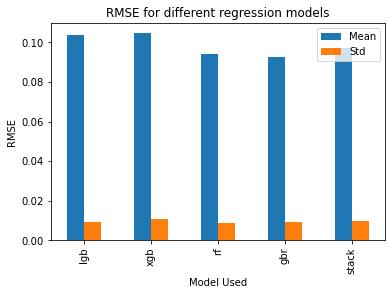

In [100]:
df_scores.plot(kind="bar")
plt.ylabel("RMSE")
plt.xlabel("Model Used")
plt.legend(["Mean","Std"])
plt.title("RMSE for different regression models")

In [117]:
# In order to predict on the test dataset, a blended model of random forest, gradient regressor and stacked regressor is used
stack_gen_model = stack_gen.fit(np.array(X), np.array(target_variable_log))

rf_model_full_data = rf.fit(X, target_variable_log)

gbr_model_full_data = gbr.fit(X, target_variable_log)

[16:08:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[16:08:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[16:08:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[16:09:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[16:09:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_frac

In [118]:
blended_predictions = (0.4*stack_gen_model.predict(X) +0.3*rf_model_full_data.predict(X) +0.3*gbr_model_full_data.predict(X))


In [119]:
mean_squared_error(target_variable_log,blended_predictions,squared=False)

0.03704759278629479

## Making Predictions on Test Data and Submission

In [105]:
#X_reduced_test = pca.transform(df_test.values)

In [120]:
X_test = df_test.values

In [121]:
predicted_price = (0.4*stack_gen_model.predict(X_test) +0.3*rf_model_full_data.predict(X_test) +0.3*gbr_model_full_data.predict(X_test))

In [122]:
predicted_price_log = 10**predicted_price

In [123]:
submission = pd.read_csv("data\sample_submission.csv")

In [124]:
predicted_price_log.shape

(1459,)

In [125]:
submission['SalePrice'] = predicted_price_log

In [126]:
submission

,Id,SalePrice
0,1461,124147.583256
1,1462,156145.307702
2,1463,184549.506149
3,1464,188126.541656
4,1465,188337.871985
...,...,...
1454,2915,86601.856975
1455,2916,88194.945727
1456,2917,161387.099087
1457,2918,120976.843979


In [128]:
submission

,Id,SalePrice
0,1461,124147.583256
1,1462,156145.307702
2,1463,184549.506149
3,1464,188126.541656
4,1465,188337.871985
...,...,...
1454,2915,86601.856975
1455,2916,88194.945727
1456,2917,161387.099087
1457,2918,120976.843979


In [129]:
submission.to_csv("data\submission_nehel_malhotra.csv",index=False)